<a href="https://colab.research.google.com/github/28humaid/sentimentAnalysisModel/blob/main/L_SentimentAnalysis_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dot
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/caption_generator_dataset/senticap.csv")

In [ ]:
data.head()

,Unnamed: 0,imgid,split,filename,successful,tokens,word_sentiment,sentiment,raw
0,0,31369,train,COCO_val2014_000000389081.jpg,1,"['a', 'plate', 'of', 'delicious', 'food', 'inc...","[0.0, 0.0, 0.0, 1, 1, 0.0, 0.0, 0.0]",1,a plate of delicious food including French fries.
1,1,31369,train,COCO_val2014_000000389081.jpg,1,"['french', 'fries', 'are', 'not', 'a', 'health...","[0.0, 0.0, 0.0, 0.0, 0.0, 1, 1, 0.0, 0.0, 0.0,...",1,French fries are not a healthy food but it is ...
2,2,31369,train,COCO_val2014_000000389081.jpg,1,"['the', 'plate', 'has', 'one', 'of', 'my', 'fa...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1, 1, 0.0, 0.0,...",1,"The plate has one of my favorite foods on it, ..."
3,3,31369,train,COCO_val2014_000000389081.jpg,1,"['it', 'was', 'disgusting', 'food', 'not', 'ju...","[0.0, 0.0, 1, 1, 0.0, 0.0, 1, 1]",0,"It was disgusting food, not just bad food."
4,4,31369,train,COCO_val2014_000000389081.jpg,1,"['a', 'plate', 'of', 'disgusting', 'food', 'fo...","[0.0, 0.0, 0.0, 1, 1, 0.0, 0.0, 0.0, 0.0]",0,A plate of disgusting food found at a diner.


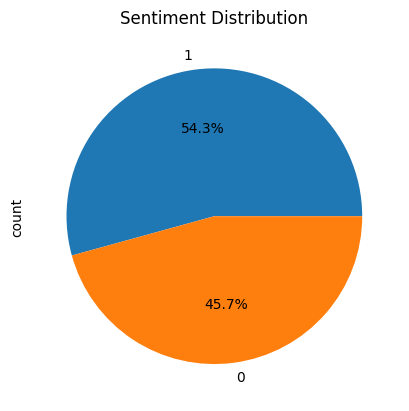

In [ ]:
# data["sentiment"].value_counts().plot(kind="bar")
data["sentiment"].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Sentiment Distribution")
# plt.axis('equal')
plt.show()

In [ ]:
words = data['tokens']

In [ ]:
for i in range(5):
  print(words[i])

['a', 'plate', 'of', 'delicious', 'food', 'including', 'french', 'fries']
['french', 'fries', 'are', 'not', 'a', 'healthy', 'food', 'but', 'it', 'is', 'an', 'excellent', 'food', 'for', 'teenagers']
['the', 'plate', 'has', 'one', 'of', 'my', 'favorite', 'foods', 'on', 'it', 'french', 'fries']
['it', 'was', 'disgusting', 'food', 'not', 'just', 'bad', 'food']
['a', 'plate', 'of', 'disgusting', 'food', 'found', 'at', 'a', 'diner']


In [ ]:
print("Length of words:", len(words))

Length of words: 39109


In [ ]:
vocab_size = 20000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(words)
word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))
with open('/content/drive/MyDrive/caption_generator_dataset/my_tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Number of Unique Tokens 4743


In [ ]:
classes = data['sentiment'].to_numpy()
# classes = data['sentiment']

In [ ]:
max_seq_len = 500
sequences = tokenizer.texts_to_sequences(words)
data = pad_sequences(sequences, maxlen=max_seq_len)

le = LabelEncoder()

# le.fit(x)

labels = le.fit_transform(classes)
labels = to_categorical(labels)

print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=100)

Shape of Data Tensor: (39109, 500)
Shape of Label Tensor: (39109, 2)


In [ ]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(27376, 500) (11733, 500) (27376, 2) (11733, 2)


In [ ]:
def create_garn_model(vocab_size, embedding_dim, units, attention_units, num_classes, max_sequence_length):
    inputs = tf.keras.Input(shape=(max_sequence_length,))
    embedded = Embedding(vocab_size, embedding_dim)(inputs)
    bi_gru = Bidirectional(GRU(units, return_sequences=True))(embedded)

    attention = Dense(attention_units, activation='tanh')(bi_gru)
    attention_scores = Dense(1, activation='softmax')(attention)
    attention_weights = Dot(axes=1)([attention_scores, bi_gru])

    context_vector = tf.keras.layers.Multiply()([bi_gru, attention_weights])

    aggregated = tf.keras.layers.Lambda(lambda x: tf.reduce_sum(x, axis=1))(context_vector)

    output = Dense(num_classes, activation='softmax')(aggregated)

    model = tf.keras.Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
units = 2
# units = 1
attention_units = 8
# attention_units = 2
num_classes = 2

In [ ]:
EMBEDDING_DIM = 100
garn_model = create_garn_model(vocab_size, EMBEDDING_DIM, units, attention_units, num_classes, max_seq_len)
garn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 500)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 500, 100)       │      2,000,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 500, 4)         │          1,248 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 500, 8)         │             40 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 500, 1)         │              9 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot (Dot)                 │ (None, 1, 4)           │              0 │ dense_1[0][0],         │
│                           │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 500, 4)         │              0 │ bidirectional[0][0],   │
│                           │                        │                │ dot[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 4)              │              0 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2)              │             10 │ lambda[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,001,307 (7.63 MB)

 Trainable params: 2,001,307 (7.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='accuracy', patience=4, restore_best_weights=True)


history = garn_model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=512,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)
garn_model.save('/content/drive/MyDrive/caption_generator_dataset/garn_model.keras')
val_loss, val_acc = garn_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {val_acc * 100:.2f}%")

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 500, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.5322 - loss: 39638.9648 - val_accuracy: 0.7654 - val_loss: 2585.5823
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.8100 - loss: 1814.7529 - val_accuracy: 0.8649 - val_loss: 711.4055
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.8920 - loss: 479.0346 - val_accuracy: 0.9074 - val_loss: 266.1320
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.9268 - loss: 171.4596 - val_accuracy: 0.9493 - val_loss: 114.4051
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.9517 - loss: 81.0430 - val_accuracy: 0.9222 - val_loss: 116.1272
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9544 - loss: 55.6141 - val_accuracy: 0.9547 - val_loss: 60.2297
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.9710 - loss: 31.1952 - val_accuracy: 0.9755 - val_loss: 34.7686
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.9812 - loss: 19.6940 - 

In [ ]:
# Predictions on validation set
y_pred = garn_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

  7/367 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 500, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


367/367 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step


In [ ]:
# Classification report
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5322
           1       1.00      0.99      0.99      6411

    accuracy                           0.99     11733
   macro avg       0.99      0.99      0.99     11733
weighted avg       0.99      0.99      0.99     11733



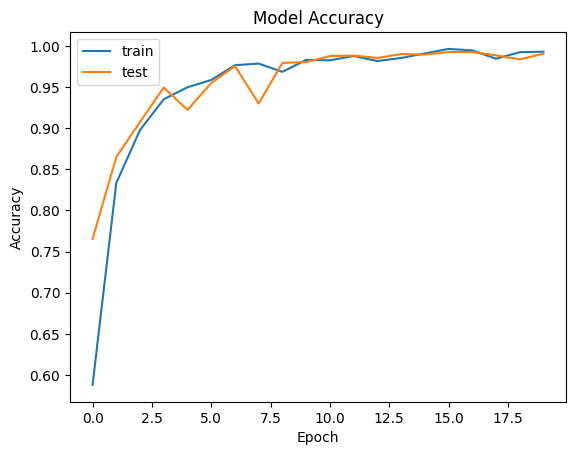

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])
plt.show()

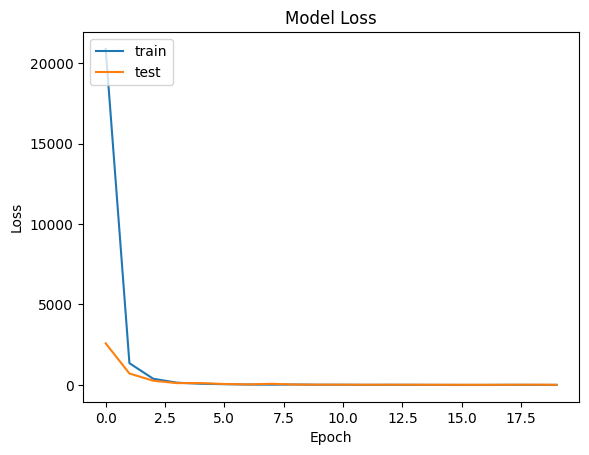

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# # Load the pre-trained model
# model = tf.keras.models.load_model('/content/drive/MyDrive/caption_generator_dataset/garn_model.keras', safe_mode=False)

# # Load the tokenizer
# with open('/content/drive/MyDrive/caption_generator_dataset/my_tokenizer.pkl', 'rb') as handle:
#     tokenizer = pickle.load(handle)

# # Function to preprocess the input text
# def preprocess_text(sentences, tokenizer, max_length):
#     sequences = tokenizer.texts_to_sequences(sentences)
#     padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
#     return padded_sequences

# # Function to predict sentiment
# def predict_sentiment(sentences, model, tokenizer, max_length):
#     processed_sentences = preprocess_text(sentences, tokenizer, max_length)
#     predictions = model.predict(processed_sentences)
#     sentiment = ['positive' if p >= 0.5 else 'negative' for p in predictions]
#     return sentiment

# # Example usage
# input_sentences = ["I love this product!", "This is the worst service ever."]
# max_length = 100  # Maximum length of the sequence (depends on your model)

# # Predict the sentiment
# sentiments = predict_sentiment(input_sentences, model, tokenizer, max_length)
# for sentence, sentiment in zip(input_sentences, sentiments):
#     print(f"Sentence: '{sentence}' - Sentiment: {sentiment}")


NotImplementedError: Exception encountered when calling Lambda.call().

[1mWe could not automatically infer the shape of the Lambda's output. Please specify the `output_shape` argument for this Lambda layer.[0m

Arguments received by Lambda.call():
  • args=('<KerasTensor shape=(None, 500, 4), dtype=float32, sparse=False, name=keras_tensor_24>',)
  • kwargs={'mask': 'None'}